<a href="https://colab.research.google.com/github/ranjanchoubey/cv-assignment/blob/master/Harris-Corner-Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harris Corner Detector

The Harris corner detector identifies points in an image where the local neighborhood shows significant changes in intensity in all directions. The key idea is to use the second moment matrix (also known as the structure tensor):

 $$ M = \begin{bmatrix} \sum I_x^2 & \sum I_x I_y \\ \sum I_x I_y & \sum I_y^2 \end{bmatrix} $$

 The corner response function is:

 $$ R = \det(M) - k \cdot (\text{trace}(M))^2 $$

 where \( k \) is a sensitivity parameter, typically set to 0.04 to 0.06.

---

**Harris Corner Detection Algorithm**

1. **Color to Grayscale**

2. **Spatial Derivative Calculation**

3. **Structure Tensor Setup**
4. **Harris Response Calculation**
5. **Non-Maximum Suppression**
6. **Grouping the Corners into One Point**


---

In [2]:
! git clone https://github.com/ranjanchoubey/cv-assignment

fatal: destination path 'cv-assignment' already exists and is not an empty directory.


In [12]:
# Import necessary libraries
from scipy import signal as sig
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np

### Step 1: Load Image

- The `load_image` function takes the path of the image as input, loads the image using `imread`, and converts it to grayscale using `rgb2gray`.
- The grayscale image simplifies the processing since we only need to work with intensity values.

In [4]:
def load_image(image_path):
    """Load an image from the specified path and convert it to grayscale."""
    img = imread(image_path)  # Load the image
    img_gray = rgb2gray(img)   # Convert to grayscale
    return img, img_gray

### Step 2: Calculate Spatial Derivatives

- The `compute_gradients` function calculates the gradients of the grayscale image using the Sobel operator.
- Two inner functions, `gradient_x` and `gradient_y`, apply the Sobel kernels to compute the gradients in the x and y directions, respectively.
- The gradients are essential for determining the changes in intensity, which helps in identifying corners.

In [5]:
def compute_gradients(img_gray):
    """Compute the gradients of the grayscale image using Sobel operators."""
    def gradient_x(img):
        # Sobel operator kernel for x direction
        kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        return sig.convolve2d(img, kernel_x, mode='same')

    def gradient_y(img):
        # Sobel operator kernel for y direction
        kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        return sig.convolve2d(img, kernel_y, mode='same')

    I_x = gradient_x(img_gray)  # Gradient in x direction
    I_y = gradient_y(img_gray)  # Gradient in y direction
    return I_x, I_y

### Step 3: Compute Structure Tensor

- The `compute_structure_tensor` function computes the components of the structure tensor.
- The structure tensor is used to analyze the local image structure and is defined by the gradients.
- Gaussian filtering is applied to smooth the gradient products, which helps in reducing noise and improving corner detection.

In [6]:
def compute_structure_tensor(I_x, I_y):
    """Compute the structure tensor components."""
    Ixx = ndi.gaussian_filter(I_x**2, sigma=1)  # Gaussian filter for Ixx
    Ixy = ndi.gaussian_filter(I_y * I_x, sigma=1)  # Gaussian filter for Ixy
    Iyy = ndi.gaussian_filter(I_y**2, sigma=1)  # Gaussian filter for Iyy
    return Ixx, Ixy, Iyy

### Step 4: Compute Harris Response

- The `compute_harris_response` function calculates the Harris response based on the structure tensor components.
- The Harris response is a measure of the corner strength at each pixel, where a high response indicates a corner.
- The parameter `k` is a sensitivity factor that can be adjusted to control the response.

In [7]:
def compute_harris_response(Ixx, Ixy, Iyy, k=0.05):
    """Calculate the Harris response using the structure tensor components."""
    detA = Ixx * Iyy - Ixy ** 2  # Determinant of the structure tensor
    traceA = Ixx + Iyy  # Trace of the structure tensor
    harris_response = detA - k * traceA ** 2  # Harris response calculation
    return harris_response

### Step 5: Non-Maximum Suppression
- The `non_maximum_suppression` function identifies corners and edges based on the Harris response values.
- It creates copies of the original image to visualize corners and edges.
- Pixels with a positive Harris response are marked as corners (red), while those with a negative response are marked as edges (green).

In [8]:
def non_maximum_suppression(harris_response, img):
    """Perform non-maximum suppression to identify corners and edges."""
    img_copy_for_corners = np.copy(img)  # Copy of the original image for corners
    img_copy_for_edges = np.copy(img)  # Copy of the original image for edges

    # Classify pixels based on Harris response
    for rowindex, response in enumerate(harris_response):
        for colindex, r in enumerate(response):
            if r > 0:
                img_copy_for_corners[rowindex, colindex] = [255, 0, 0]  # Mark corner in red
            elif r < 0:
                img_copy_for_edges[rowindex, colindex] = [0, 255, 0]  # Mark edge in green

    return img_copy_for_corners, img_copy_for_edges

### Step 6: Visualize Results
- The `visualize_results` function displays the images with detected corners and edges side by side.
- This helps in visually assessing the performance of the Harris corner detection algorithm.

In [9]:
def visualize_results(img, img_corners, img_edges):
    """Visualize the corners and edges found in the image."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    ax[0].set_title("Corners Found")
    ax[0].imshow(img_corners)
    ax[1].set_title("Edges Found")
    ax[1].imshow(img_edges)
    plt.show()

### Step 7: Detect Corners Using Peaks
- The `detect_corners_with_peaks` function uses the `corner_peaks` function from `skimage` to find local maxima in the Harris response.
- Detected corners are plotted on the original image, providing a clear visualization of the corner detection results.

In [10]:
from skimage.feature import corner_peaks, corner_harris
def detect_corners_with_peaks(harris_response, img):
    """Detect corners using the corner_peaks function from skimage."""
    corners = corner_peaks(harris_response)  # Find local maxima of the Harris response
    fig, ax = plt.subplots()
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    ax.plot(corners[:, 1], corners[:, 0], '.r', markersize=3)  # Plot detected corners
    plt.title("Detected Corners")
    plt.show()

### **Main Function**


Loading image...
Image loaded.

 Computing gradients...
Gradients computed.

 Computing structure tensor...
Structure tensor computed.

 Computing Harris response...
Harris response computed.

 Performing non-maximum suppression...
Non-maximum suppression completed.

 Visualizing results...


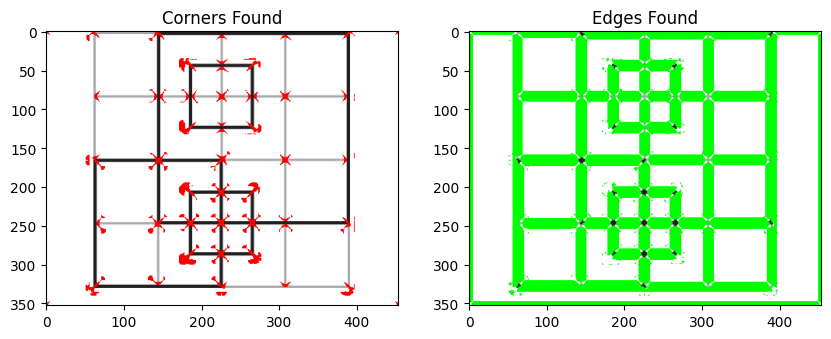

Results visualized.

 Detecting corners using peaks...


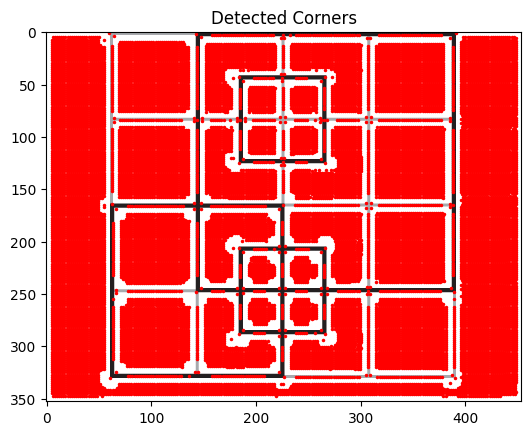

Corner detection completed. done!!!


In [13]:
def main(image_path):

    print("Loading image...")
    img, img_gray = load_image(image_path)  # Load and convert image

    print("Image loaded.\n\n Computing gradients...")
    I_x, I_y = compute_gradients(img_gray)  # Compute gradients

    print("Gradients computed.\n\n Computing structure tensor...")
    Ixx, Ixy, Iyy = compute_structure_tensor(I_x, I_y)  # Compute structure tensor

    print("Structure tensor computed.\n\n Computing Harris response...")
    harris_response = compute_harris_response(Ixx, Ixy, Iyy)  # Compute Harris response

    print("Harris response computed.\n\n Performing non-maximum suppression...")
    img_corners, img_edges = non_maximum_suppression(harris_response, img)  # Non-maximum suppression

    print("Non-maximum suppression completed.\n\n Visualizing results...")
    visualize_results(img, img_corners, img_edges)  # Visualize results

    print("Results visualized.\n\n Detecting corners using peaks...This will take some time. Wait ....")
    detect_corners_with_peaks(harris_response, img)  # Detect corners using peaks

    print("Corner detection completed. done!!!")

if __name__ == "__main__":
    main('cv-assignment/assets/box.jpg')

## Harris Corner Detection Using `skimage` Library

We can also use the `corner_harris` and `corner_peaks` functions from the `skimage` library for a more straightforward implementation.

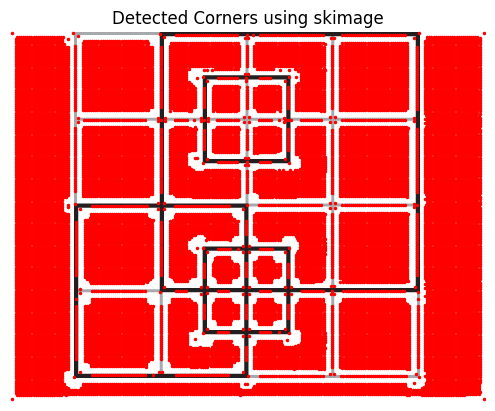

In [14]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks

# Step 1: Load the image
image_path = 'cv-assignment/assets/box.jpg'
img = imread(image_path)  # Load the image
imggray = rgb2gray(img)   # Convert to grayscale

# Step 2: Calculate Harris response using skimage
skimage_harris_response = corner_harris(imggray)

# Step 3: Find local maxima of the Harris response
coords = corner_peaks(skimage_harris_response)

# Step 4: Visualize the corners
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.r', markersize=3)  # Plot detected corners
plt.title("Detected Corners using skimage")
plt.axis('off')  # Hide axis
plt.show()

End

---